### Predicting the type of crime going to happen in a location using

##### Importing the necessary libraries

In [892]:
import pandas as pd

##### Importing the dataset

In [893]:
crimes_df = pd.read_csv('Crimes-2019_to_2021.csv')
crimes_df.head(5)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,11552667,JC100123,1/1/19 0:00,004XX N STATE ST,890,THEFT,FROM BUILDING,RESTAURANT,False,False,...,42.0,8.0,6,1176302.0,1903096.0,2019,1/10/19 15:16,41.889453,-87.627995,"(41.889453169, -87.627994833)"
1,11552674,JC100085,1/1/19 0:00,092XX S NORMAL AVE,910,MOTOR VEHICLE THEFT,AUTOMOBILE,STREET,False,False,...,21.0,73.0,7,1174586.0,1843723.0,2019,1/10/19 15:16,41.726566,-87.636066,"(41.726566477, -87.636065622)"
2,11552709,JC100020,1/1/19 0:00,044XX S WASHTENAW AVE,486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,...,15.0,58.0,08B,1159112.0,1875020.0,2019,1/10/19 15:16,41.812780,-87.691894,"(41.812780011, -87.691893746)"
3,11552758,JC100058,1/1/19 0:00,063XX S MARSHFIELD AVE,1310,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,False,False,...,16.0,67.0,14,1166414.0,1862607.0,2019,1/10/19 15:16,41.778565,-87.665464,"(41.77856457, -87.665463557)"
4,11553168,JC100745,1/1/19 0:00,008XX N MICHIGAN AVE,890,THEFT,FROM BUILDING,RESTAURANT,False,False,...,2.0,8.0,6,1177330.0,1906499.0,2019,1/10/19 15:16,41.898768,-87.624116,"(41.898767916, -87.624116333)"


In [894]:
# printing datatypes 
crimes_df.dtypes

ID                        int64
Case Number              object
Date                     object
Block                    object
IUCR                     object
Primary Type             object
Description              object
Location Description     object
Arrest                     bool
Domestic                   bool
Beat                      int64
District                  int64
Ward                    float64
Community Area          float64
FBI Code                 object
X Coordinate            float64
Y Coordinate            float64
Year                      int64
Updated On               object
Latitude                float64
Longitude               float64
Location                 object
dtype: object

In [895]:
# shape of dataset before cleaning
crimes_df.shape

(680425, 22)

##### Converting the column names to a standard form and handling inconsistencies

In [896]:
crimes_df.columns =crimes_df.columns.str.strip()
crimes_df.columns = crimes_df.columns.str.replace(' ', '_')
crimes_df.columns = crimes_df.columns.str.lower()

##### Checking for outliers 

<AxesSubplot: >

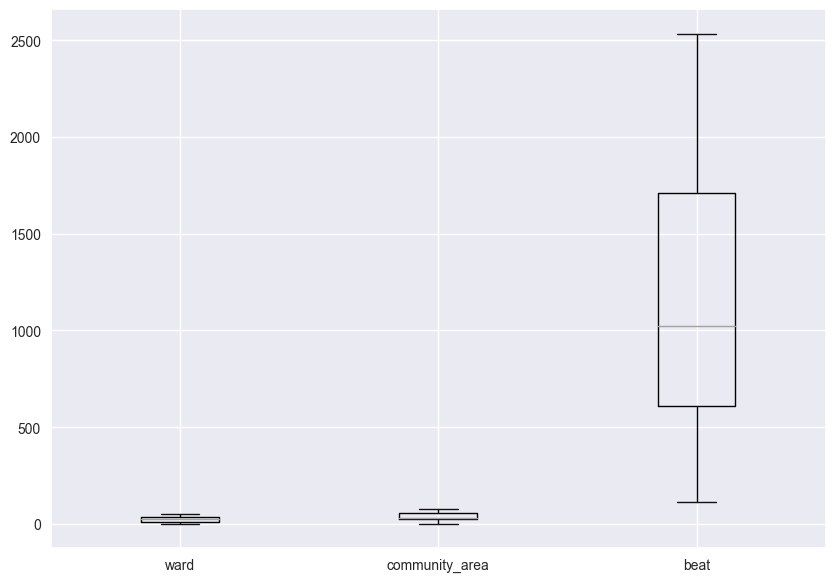

In [897]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 7))
crimes_df.boxplot(['ward','community_area','beat'])

##### Eliminating duplicate rows

In [898]:
crimes_df=crimes_df.drop_duplicates()

##### Handling missing values by dropping, replacing them 

In [ ]:
import missingno as msno 
msno.dendrogram(crimes_df)

In [899]:
crimes_df.dropna(subset = ['latitude','longitude','ward'], inplace = True)
crimes_df.reset_index(drop = True, inplace = True)
crimes_df['location_description'] = crimes_df['location_description'].fillna('Unavailable')

The x coordinate and y coordinate values are closely correlated with the null values of latitude and longitude, as can be seen from the dendogram above. If one of the values in this co-relation has a value of 1, it means that the other value likewise has a value of 1.

Therefore, it is safe to discard observations in which one of the values is zero. This shouldn't have an impact on our data and should also prevent the loss of significant observations.

##### Checking if there are any null values

In [900]:
crimes_df.isna().sum()

id                      0
case_number             0
date                    0
block                   0
iucr                    0
primary_type            0
description             0
location_description    0
arrest                  0
domestic                0
beat                    0
district                0
ward                    0
community_area          0
fbi_code                0
x_coordinate            0
y_coordinate            0
year                    0
updated_on              0
latitude                0
longitude               0
location                0
dtype: int64

In [901]:
# size of data after cleaning
crimes_df.size

14739450

### Predicting the type of crime going to happen in a location

## Decision tree Classifier

In [902]:
import matplotlib.pyplot as plt
import numpy as np
#import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn import tree

# MAKE A REFERENCE ON HOW DID YOU MAKE THIS

In [903]:
#Mapping similar crimes under one group.
primary_type_map = {
    ('BURGLARY','MOTOR VEHICLE THEFT','THEFT','ROBBERY') : 'THEFT',
    ('BATTERY','ASSAULT','NON-CRIMINAL','NON-CRIMINAL (SUBJECT SPECIFIED)') : 'NON-CRIMINAL_ASSAULT',
    ('CRIM SEXUAL ASSAULT','SEX OFFENSE','STALKING','PROSTITUTION') : 'SEXUAL_OFFENSE',
    ('WEAPONS VIOLATION','CONCEALED CARRY LICENSE VIOLATION') :  'WEAPONS_OFFENSE',
    ('HOMICIDE','CRIMINAL DAMAGE','DECEPTIVE PRACTICE','CRIMINAL TRESPASS') : 'CRIMINAL_OFFENSE',
    ('KIDNAPPING','HUMAN TRAFFICKING','OFFENSE INVOLVING CHILDREN') : 'HUMAN_TRAFFICKING_OFFENSE',
    ('NARCOTICS','OTHER NARCOTIC VIOLATION') : 'NARCOTIC_OFFENSE',
    ('OTHER OFFENSE','ARSON','GAMBLING','PUBLIC PEACE VIOLATION','INTIMIDATION','INTERFERENCE WITH PUBLIC OFFICER','LIQUOR LAW VIOLATION','OBSCENITY','PUBLIC INDECENCY') : 'OTHER_OFFENSE'
}
primary_type_mapping = {}
for keys, values in primary_type_map.items():
    for key in keys:
        primary_type_mapping[key] = values
crimes_df['primary_type_grouped'] = crimes_df.primary_type.map(primary_type_mapping)

In [904]:
#Converting the numercial attributes to categorical attributes
crimes_df.year = pd.Categorical(crimes_df.year)
crimes_df.domestic = pd.Categorical(crimes_df.domestic)
crimes_df.arrest = pd.Categorical(crimes_df.arrest)
crimes_df.beat = pd.Categorical(crimes_df.beat)
crimes_df.district = pd.Categorical(crimes_df.district)
crimes_df.community_area = pd.Categorical(crimes_df.community_area)

In [905]:
# Making a new dataframe for the model with features used
crimes_data_type = crimes_df.loc[crimes_df.primary_type_grouped.isin(['THEFT','SEXUAL_OFFENSE','WEAPONS_OFFENSE'])]
crimes_data_type.head()



,id,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,...,community_area,fbi_code,x_coordinate,y_coordinate,year,updated_on,latitude,longitude,location,primary_type_grouped
0,11552667,JC100123,1/1/19 0:00,004XX N STATE ST,890,THEFT,FROM BUILDING,RESTAURANT,False,False,...,8.0,6,1176302.0,1903096.0,2019,1/10/19 15:16,41.889453,-87.627995,"(41.889453169, -87.627994833)",THEFT
1,11552674,JC100085,1/1/19 0:00,092XX S NORMAL AVE,910,MOTOR VEHICLE THEFT,AUTOMOBILE,STREET,False,False,...,73.0,7,1174586.0,1843723.0,2019,1/10/19 15:16,41.726566,-87.636066,"(41.726566477, -87.636065622)",THEFT
4,11553168,JC100745,1/1/19 0:00,008XX N MICHIGAN AVE,890,THEFT,FROM BUILDING,RESTAURANT,False,False,...,8.0,6,1177330.0,1906499.0,2019,1/10/19 15:16,41.898768,-87.624116,"(41.898767916, -87.624116333)",THEFT
6,11553495,JC101115,1/1/19 0:00,047XX N RACINE AVE,281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,OTHER,False,False,...,3.0,2,1167451.0,1931818.0,2019,1/10/19 15:16,41.968463,-87.659670,"(41.968462892, -87.659670442)",SEXUAL_OFFENSE
9,11558163,JC106702,1/1/19 0:00,002XX W ONTARIO ST,890,THEFT,FROM BUILDING,BAR OR TAVERN,False,False,...,8.0,6,1174469.0,1904439.0,2019,1/10/19 15:16,41.893180,-87.634686,"(41.893179585, -87.634686145)",THEFT


In [906]:
crimes_data_type['primary_type_grouped'] = crimes_data_type.primary_type_grouped.astype('category').cat.codes


C:\Users\syarla3\AppData\Local\Temp\ipykernel_27980\2508616501.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crimes_data_type['primary_type_grouped'] = crimes_data_type.primary_type_grouped.astype('category').cat.codes


In [907]:
crimes_data_type.head()

,id,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,...,community_area,fbi_code,x_coordinate,y_coordinate,year,updated_on,latitude,longitude,location,primary_type_grouped
0,11552667,JC100123,1/1/19 0:00,004XX N STATE ST,890,THEFT,FROM BUILDING,RESTAURANT,False,False,...,8.0,6,1176302.0,1903096.0,2019,1/10/19 15:16,41.889453,-87.627995,"(41.889453169, -87.627994833)",1
1,11552674,JC100085,1/1/19 0:00,092XX S NORMAL AVE,910,MOTOR VEHICLE THEFT,AUTOMOBILE,STREET,False,False,...,73.0,7,1174586.0,1843723.0,2019,1/10/19 15:16,41.726566,-87.636066,"(41.726566477, -87.636065622)",1
4,11553168,JC100745,1/1/19 0:00,008XX N MICHIGAN AVE,890,THEFT,FROM BUILDING,RESTAURANT,False,False,...,8.0,6,1177330.0,1906499.0,2019,1/10/19 15:16,41.898768,-87.624116,"(41.898767916, -87.624116333)",1
6,11553495,JC101115,1/1/19 0:00,047XX N RACINE AVE,281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,OTHER,False,False,...,3.0,2,1167451.0,1931818.0,2019,1/10/19 15:16,41.968463,-87.659670,"(41.968462892, -87.659670442)",0
9,11558163,JC106702,1/1/19 0:00,002XX W ONTARIO ST,890,THEFT,FROM BUILDING,BAR OR TAVERN,False,False,...,8.0,6,1174469.0,1904439.0,2019,1/10/19 15:16,41.893180,-87.634686,"(41.893179585, -87.634686145)",1


In [908]:
# Dropping unnecessary columns which are not required for this prediction  
crimes_data_prediction = crimes_data_type.drop(['id','case_number','location','date','block','iucr','description','location_description','primary_type','fbi_code','updated_on','x_coordinate','y_coordinate','primary_type_grouped'],axis=1)


In [909]:
crimes_data_prediction_type=crimes_data_type[['primary_type_grouped']]

In [910]:
crimes_data_prediction_type.head()

,primary_type_grouped
0,1
1,1
4,1
6,0
9,1


In [911]:
crimes_data_prediction.head()

,arrest,domestic,beat,district,ward,community_area,year,latitude,longitude
0,False,False,1831,18,42.0,8.0,2019,41.889453,-87.627995
1,False,False,2223,22,21.0,73.0,2019,41.726566,-87.636066
4,False,False,1833,18,2.0,8.0,2019,41.898768,-87.624116
6,False,False,1913,19,46.0,3.0,2019,41.968463,-87.659670
9,False,False,1831,18,42.0,8.0,2019,41.893180,-87.634686


In [912]:
crimes_data_prediction_type.head()

,primary_type_grouped
0,1
1,1
4,1
6,0
9,1


In [913]:
# formulating into 2 dimentional binary matrix 
#crimes_data_prediction = pd.get_dummies(crimes_data_prediction,drop_first=True)
#crimes_data_prediction.head()

In [914]:
crimes_data_prediction=crimes_data_prediction.to_numpy()
crimes_data_prediction_type=crimes_data_prediction_type.to_numpy()

##### Keeping grouped primary type of crime as target feature (i.e crimes_data_prediction_type)

In [915]:
# Spliting the data into training and testing where test size as 30%
XX_train, XX_test, yy_train, yy_test = train_test_split(crimes_data_prediction,crimes_data_prediction_type, test_size=0.3, random_state=42)

In [916]:
XX_train.shape,XX_test.shape,yy_test.shape,yy_train.shape

((174488, 9), (74781, 9), (74781, 1), (174488, 1))

In [917]:
# Using the model from sklearn and fitting it.

model = tree.DecisionTreeClassifier(criterion = "entropy", random_state = 42)
model.fit(XX_train, yy_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [918]:
# Making predictions
yy_pred = model.predict(XX_test)

In [919]:
#Classification Metrics
from sklearn.metrics import confusion_matrix
print('Accuracy = ',metrics.accuracy_score(yy_test, yy_pred))
print('Error = ',1 - metrics.accuracy_score(yy_test, yy_pred))
print('Classification Report\n',metrics.classification_report(yy_test, yy_pred))
#conff_matrix = pd. crosstab(yy_test,yy_pred)


Accuracy =  0.877816557681764
Error =  0.12218344231823597
Classification Report
               precision    recall  f1-score   support

           0       0.21      0.23      0.22      1830
           1       0.93      0.93      0.93     65663
           2       0.56      0.53      0.55      7288

    accuracy                           0.88     74781
   macro avg       0.57      0.57      0.57     74781
weighted avg       0.88      0.88      0.88     74781



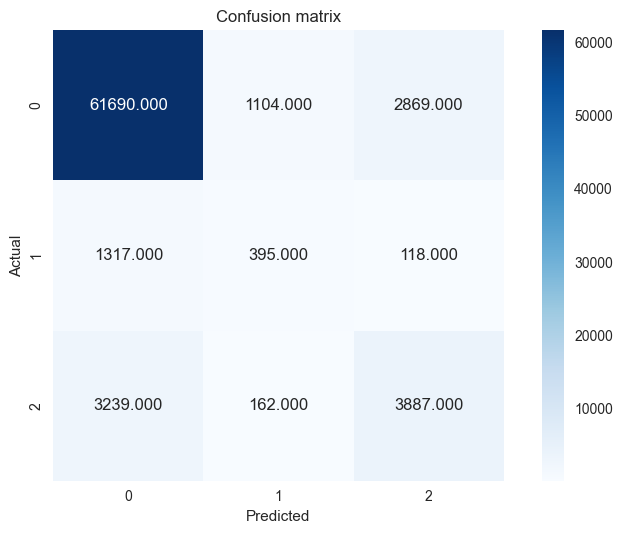

In [920]:
#Visualization of Confusion Matrix
import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")
sns.heatmap(conff_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

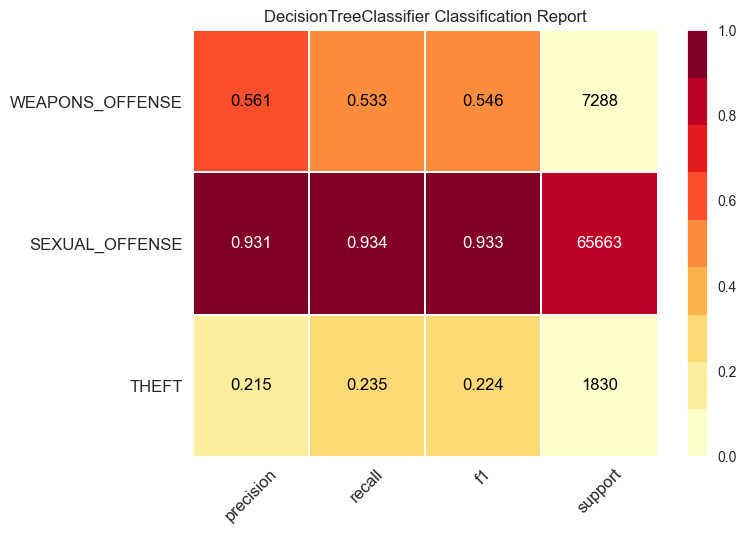

<AxesSubplot: title={'center': 'DecisionTreeClassifier Classification Report'}>

In [921]:
from yellowbrick.classifier import ClassificationReport
classes=['THEFT','SEXUAL_OFFENSE','WEAPONS_OFFENSE']

visualizer = ClassificationReport(model, classes=classes, support=True)

visualizer.fit(XX_train, yy_train)        # Fit the visualizer and the model
visualizer.score(XX_test, yy_test)        # Evaluate the model on the test data
visualizer.show() 

## Observation: By classification report,
- Precision: In the case where theft was predicted as positive 21% were correctly predicted. 
- Recall: In the case of an sexual_offense 93% were classified correctly when an actual arrest happened.
- f1: The weighted harmonic mean of precision and recall is a good value if its closer to 1 and this is almost close to 1 in this case.So it a good model.
- Support: This shows the number of actual occurences of the classes in teh dataset we see that we have 1830 instances of theft whereas 65663 instances of sexual_offense and 7288 instances of weapon offense.

### Accuracy for Decision tree classifier : 88%

## Random Forest Classifier

In [922]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn import tree


##### Importing the dataset

In [923]:
crimes_df = pd.read_csv('Crimes-2019_to_2021.csv')
crimes_df.head(5)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,11552667,JC100123,1/1/19 0:00,004XX N STATE ST,890,THEFT,FROM BUILDING,RESTAURANT,False,False,...,42.0,8.0,6,1176302.0,1903096.0,2019,1/10/19 15:16,41.889453,-87.627995,"(41.889453169, -87.627994833)"
1,11552674,JC100085,1/1/19 0:00,092XX S NORMAL AVE,910,MOTOR VEHICLE THEFT,AUTOMOBILE,STREET,False,False,...,21.0,73.0,7,1174586.0,1843723.0,2019,1/10/19 15:16,41.726566,-87.636066,"(41.726566477, -87.636065622)"
2,11552709,JC100020,1/1/19 0:00,044XX S WASHTENAW AVE,486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,...,15.0,58.0,08B,1159112.0,1875020.0,2019,1/10/19 15:16,41.812780,-87.691894,"(41.812780011, -87.691893746)"
3,11552758,JC100058,1/1/19 0:00,063XX S MARSHFIELD AVE,1310,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,False,False,...,16.0,67.0,14,1166414.0,1862607.0,2019,1/10/19 15:16,41.778565,-87.665464,"(41.77856457, -87.665463557)"
4,11553168,JC100745,1/1/19 0:00,008XX N MICHIGAN AVE,890,THEFT,FROM BUILDING,RESTAURANT,False,False,...,2.0,8.0,6,1177330.0,1906499.0,2019,1/10/19 15:16,41.898768,-87.624116,"(41.898767916, -87.624116333)"


##### Converting the column names to a standard form and handling inconsistencies

In [924]:
crimes_df.columns =crimes_df.columns.str.strip()
crimes_df.columns = crimes_df.columns.str.replace(' ', '_')
crimes_df.columns = crimes_df.columns.str.lower()

##### Eliminating duplicate rows

In [925]:
crimes_df=crimes_df.drop_duplicates()

##### Handling missing values by dropping, replacing them 

In [926]:
crimes_df.dropna(subset = ['latitude','longitude','ward'], inplace = True)
crimes_df.reset_index(drop = True, inplace = True)
crimes_df['location_description'] = crimes_df['location_description'].fillna('Unavailable')

##### Checking if there are any null values

In [927]:
crimes_df.isna().sum()

id                      0
case_number             0
date                    0
block                   0
iucr                    0
primary_type            0
description             0
location_description    0
arrest                  0
domestic                0
beat                    0
district                0
ward                    0
community_area          0
fbi_code                0
x_coordinate            0
y_coordinate            0
year                    0
updated_on              0
latitude                0
longitude               0
location                0
dtype: int64

In [928]:
#Mapping similar crimes under one group.
primary_type_map = {
    ('BURGLARY','MOTOR VEHICLE THEFT','THEFT','ROBBERY') : 'THEFT',
    ('BATTERY','ASSAULT','NON-CRIMINAL','NON-CRIMINAL (SUBJECT SPECIFIED)') : 'NON-CRIMINAL_ASSAULT',
    ('CRIM SEXUAL ASSAULT','SEX OFFENSE','STALKING','PROSTITUTION') : 'SEXUAL_OFFENSE',
    ('WEAPONS VIOLATION','CONCEALED CARRY LICENSE VIOLATION') :  'WEAPONS_OFFENSE',
    ('HOMICIDE','CRIMINAL DAMAGE','DECEPTIVE PRACTICE','CRIMINAL TRESPASS') : 'CRIMINAL_OFFENSE',
    ('KIDNAPPING','HUMAN TRAFFICKING','OFFENSE INVOLVING CHILDREN') : 'HUMAN_TRAFFICKING_OFFENSE',
    ('NARCOTICS','OTHER NARCOTIC VIOLATION') : 'NARCOTIC_OFFENSE',
    ('OTHER OFFENSE','ARSON','GAMBLING','PUBLIC PEACE VIOLATION','INTIMIDATION','INTERFERENCE WITH PUBLIC OFFICER','LIQUOR LAW VIOLATION','OBSCENITY','PUBLIC INDECENCY') : 'OTHER_OFFENSE'
}
primary_type_mapping = {}
for keys, values in primary_type_map.items():
    for key in keys:
        primary_type_mapping[key] = values
crimes_df['primary_type_grouped'] = crimes_df.primary_type.map(primary_type_mapping)

In [929]:
#Converting the numercial attributes to categorical attributes
crimes_df.year = pd.Categorical(crimes_df.year)
crimes_df.domestic = pd.Categorical(crimes_df.domestic)
crimes_df.arrest = pd.Categorical(crimes_df.arrest)
crimes_df.beat = pd.Categorical(crimes_df.beat)
crimes_df.district = pd.Categorical(crimes_df.district)
crimes_df.community_area = pd.Categorical(crimes_df.community_area)

In [930]:
# Making a new dataframe for the model with features used
crimes_data_type = crimes_df.loc[crimes_df.primary_type_grouped.isin(['THEFT','SEXUAL_OFFENSE','WEAPONS_OFFENSE'])]
crimes_data_type.head()


,id,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,...,community_area,fbi_code,x_coordinate,y_coordinate,year,updated_on,latitude,longitude,location,primary_type_grouped
0,11552667,JC100123,1/1/19 0:00,004XX N STATE ST,890,THEFT,FROM BUILDING,RESTAURANT,False,False,...,8.0,6,1176302.0,1903096.0,2019,1/10/19 15:16,41.889453,-87.627995,"(41.889453169, -87.627994833)",THEFT
1,11552674,JC100085,1/1/19 0:00,092XX S NORMAL AVE,910,MOTOR VEHICLE THEFT,AUTOMOBILE,STREET,False,False,...,73.0,7,1174586.0,1843723.0,2019,1/10/19 15:16,41.726566,-87.636066,"(41.726566477, -87.636065622)",THEFT
4,11553168,JC100745,1/1/19 0:00,008XX N MICHIGAN AVE,890,THEFT,FROM BUILDING,RESTAURANT,False,False,...,8.0,6,1177330.0,1906499.0,2019,1/10/19 15:16,41.898768,-87.624116,"(41.898767916, -87.624116333)",THEFT
6,11553495,JC101115,1/1/19 0:00,047XX N RACINE AVE,281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,OTHER,False,False,...,3.0,2,1167451.0,1931818.0,2019,1/10/19 15:16,41.968463,-87.659670,"(41.968462892, -87.659670442)",SEXUAL_OFFENSE
9,11558163,JC106702,1/1/19 0:00,002XX W ONTARIO ST,890,THEFT,FROM BUILDING,BAR OR TAVERN,False,False,...,8.0,6,1174469.0,1904439.0,2019,1/10/19 15:16,41.893180,-87.634686,"(41.893179585, -87.634686145)",THEFT


In [931]:
crimes_data_type['primary_type_grouped'] = crimes_data_type.primary_type_grouped.astype('category').cat.codes

C:\Users\syarla3\AppData\Local\Temp\ipykernel_27980\3410947807.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crimes_data_type['primary_type_grouped'] = crimes_data_type.primary_type_grouped.astype('category').cat.codes


In [932]:
crimes_data_type.head()

,id,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,...,community_area,fbi_code,x_coordinate,y_coordinate,year,updated_on,latitude,longitude,location,primary_type_grouped
0,11552667,JC100123,1/1/19 0:00,004XX N STATE ST,890,THEFT,FROM BUILDING,RESTAURANT,False,False,...,8.0,6,1176302.0,1903096.0,2019,1/10/19 15:16,41.889453,-87.627995,"(41.889453169, -87.627994833)",1
1,11552674,JC100085,1/1/19 0:00,092XX S NORMAL AVE,910,MOTOR VEHICLE THEFT,AUTOMOBILE,STREET,False,False,...,73.0,7,1174586.0,1843723.0,2019,1/10/19 15:16,41.726566,-87.636066,"(41.726566477, -87.636065622)",1
4,11553168,JC100745,1/1/19 0:00,008XX N MICHIGAN AVE,890,THEFT,FROM BUILDING,RESTAURANT,False,False,...,8.0,6,1177330.0,1906499.0,2019,1/10/19 15:16,41.898768,-87.624116,"(41.898767916, -87.624116333)",1
6,11553495,JC101115,1/1/19 0:00,047XX N RACINE AVE,281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,OTHER,False,False,...,3.0,2,1167451.0,1931818.0,2019,1/10/19 15:16,41.968463,-87.659670,"(41.968462892, -87.659670442)",0
9,11558163,JC106702,1/1/19 0:00,002XX W ONTARIO ST,890,THEFT,FROM BUILDING,BAR OR TAVERN,False,False,...,8.0,6,1174469.0,1904439.0,2019,1/10/19 15:16,41.893180,-87.634686,"(41.893179585, -87.634686145)",1


In [933]:
# Dropping unnecessary columns which are not required for this prediction  
crimes_data_prediction = crimes_data_type.drop(['id','case_number','location','date','block','iucr','description','location_description','primary_type','fbi_code','updated_on','x_coordinate','y_coordinate','primary_type_grouped'],axis=1)

In [934]:
crimes_data_prediction_type=crimes_data_type[['primary_type_grouped']]

In [935]:
crimes_data_prediction=crimes_data_prediction.to_numpy()
crimes_data_prediction_type=crimes_data_prediction_type.to_numpy()

In [936]:
# Spliting the data into training and testing where test size as 30%
XX_train, XX_test, yy_train, yy_test = train_test_split(crimes_data_prediction,crimes_data_prediction_type, test_size=0.3, random_state=42)

In [937]:
from sklearn.ensemble import RandomForestClassifier
modell = RandomForestClassifier(n_estimators = 10,criterion='entropy',random_state=42)
modell.fit(XX_train,yy_train)

C:\Users\syarla3\AppData\Local\Temp\ipykernel_27980\12668443.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modell.fit(XX_train,yy_train)


RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=42)

In [938]:
yy_pred = modell.predict(XX_test)

In [939]:
#Classification Metrics
from sklearn.metrics import confusion_matrix
print('Accuracy = ',metrics.accuracy_score(yy_test, yy_pred))
print('Error = ',1 - metrics.accuracy_score(yy_test, yy_pred))
print('Classification Report\n',metrics.classification_report(yy_test, yy_pred))

Accuracy =  0.9048287666653294
Error =  0.09517123333467059
Classification Report
               precision    recall  f1-score   support

           0       0.34      0.20      0.26      1830
           1       0.93      0.96      0.95     65663
           2       0.69      0.54      0.60      7288

    accuracy                           0.90     74781
   macro avg       0.66      0.57      0.60     74781
weighted avg       0.89      0.90      0.90     74781



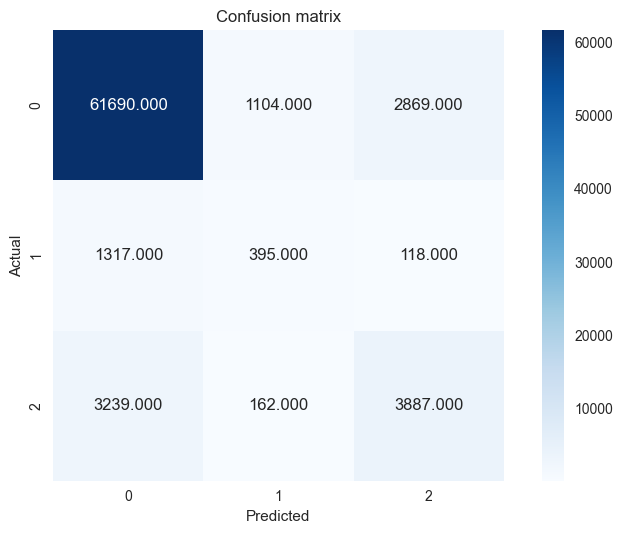

In [940]:
#Visualization of Confusion Matrix
import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")
sns.heatmap(conff_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

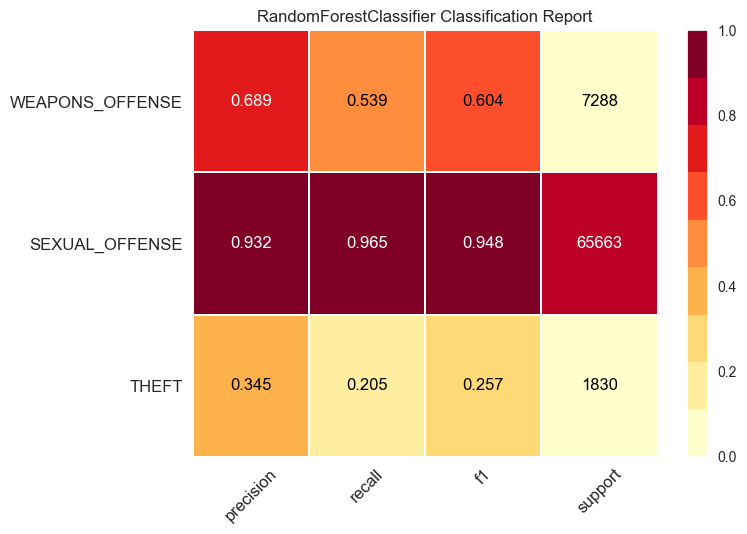

<AxesSubplot: title={'center': 'RandomForestClassifier Classification Report'}>

In [1001]:
from yellowbrick.classifier import ClassificationReport
classes=['THEFT','SEXUAL_OFFENSE','WEAPONS_OFFENSE']

visualizer = ClassificationReport(modell, classes=classes, support=True)

visualizer.fit(XX_train, yy_train)        # Fit the visualizer and the model
visualizer.score(XX_test, yy_test)        # Evaluate the model on the test data
visualizer.show() 

## Observation: By classification report,
- Precision: In the case where theft was predicted as positive 34% were correctly predicted. 
- Recall: In the case of an sexual_offense 96% were classified correctly when an actual arrest happened.
- f1: The weighted harmonic mean of precision and recall is a good value if its closer to 1 and this is almost close to 1 in this case.So it a good model.
- Support: This shows the number of actual occurences of the classes in teh dataset we see that we have 1830 instances of theft whereas 65663 instances of sexual_offense and 7288 instances of weapon offense.

By using Random Forest machine learnng model the accuracy is increased when compared to Decision tree classifier.

## Additional Work

### To predict whether the crime would lead to arrest or not

### Gaussain Naive Bayes

##### Importing the necessary libraries

In [975]:
import pandas as pd

In [976]:
crimes_df = pd.read_csv('Crimes-2019_to_2021.csv')
crimes_df.head(5)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,11552667,JC100123,1/1/19 0:00,004XX N STATE ST,890,THEFT,FROM BUILDING,RESTAURANT,False,False,...,42.0,8.0,6,1176302.0,1903096.0,2019,1/10/19 15:16,41.889453,-87.627995,"(41.889453169, -87.627994833)"
1,11552674,JC100085,1/1/19 0:00,092XX S NORMAL AVE,910,MOTOR VEHICLE THEFT,AUTOMOBILE,STREET,False,False,...,21.0,73.0,7,1174586.0,1843723.0,2019,1/10/19 15:16,41.726566,-87.636066,"(41.726566477, -87.636065622)"
2,11552709,JC100020,1/1/19 0:00,044XX S WASHTENAW AVE,486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,...,15.0,58.0,08B,1159112.0,1875020.0,2019,1/10/19 15:16,41.812780,-87.691894,"(41.812780011, -87.691893746)"
3,11552758,JC100058,1/1/19 0:00,063XX S MARSHFIELD AVE,1310,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,False,False,...,16.0,67.0,14,1166414.0,1862607.0,2019,1/10/19 15:16,41.778565,-87.665464,"(41.77856457, -87.665463557)"
4,11553168,JC100745,1/1/19 0:00,008XX N MICHIGAN AVE,890,THEFT,FROM BUILDING,RESTAURANT,False,False,...,2.0,8.0,6,1177330.0,1906499.0,2019,1/10/19 15:16,41.898768,-87.624116,"(41.898767916, -87.624116333)"


In [977]:
# shape of dataset before cleaning
crimes_df.shape

(680425, 22)

##### Converting the column names to a standard form and handling inconsistencies

In [978]:
crimes_df.columns =crimes_df.columns.str.strip()
crimes_df.columns = crimes_df.columns.str.replace(' ', '_')
crimes_df.columns = crimes_df.columns.str.lower()

##### Checking for outliers 

<AxesSubplot: >

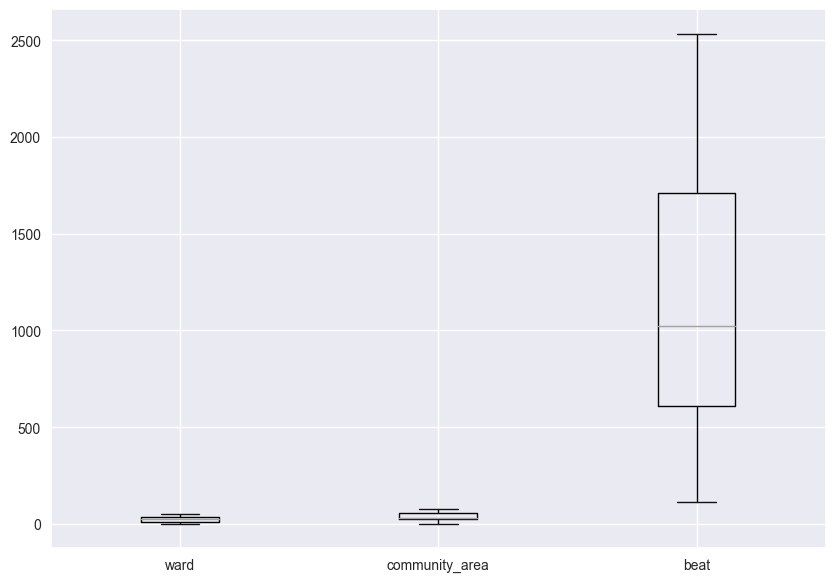

In [979]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 7))
crimes_df.boxplot(['ward','community_area','beat'])

##### Eliminating duplicate rows

In [980]:
crimes_df=crimes_df.drop_duplicates()

##### Handling missing values by dropping, replacing them 

<AxesSubplot: >

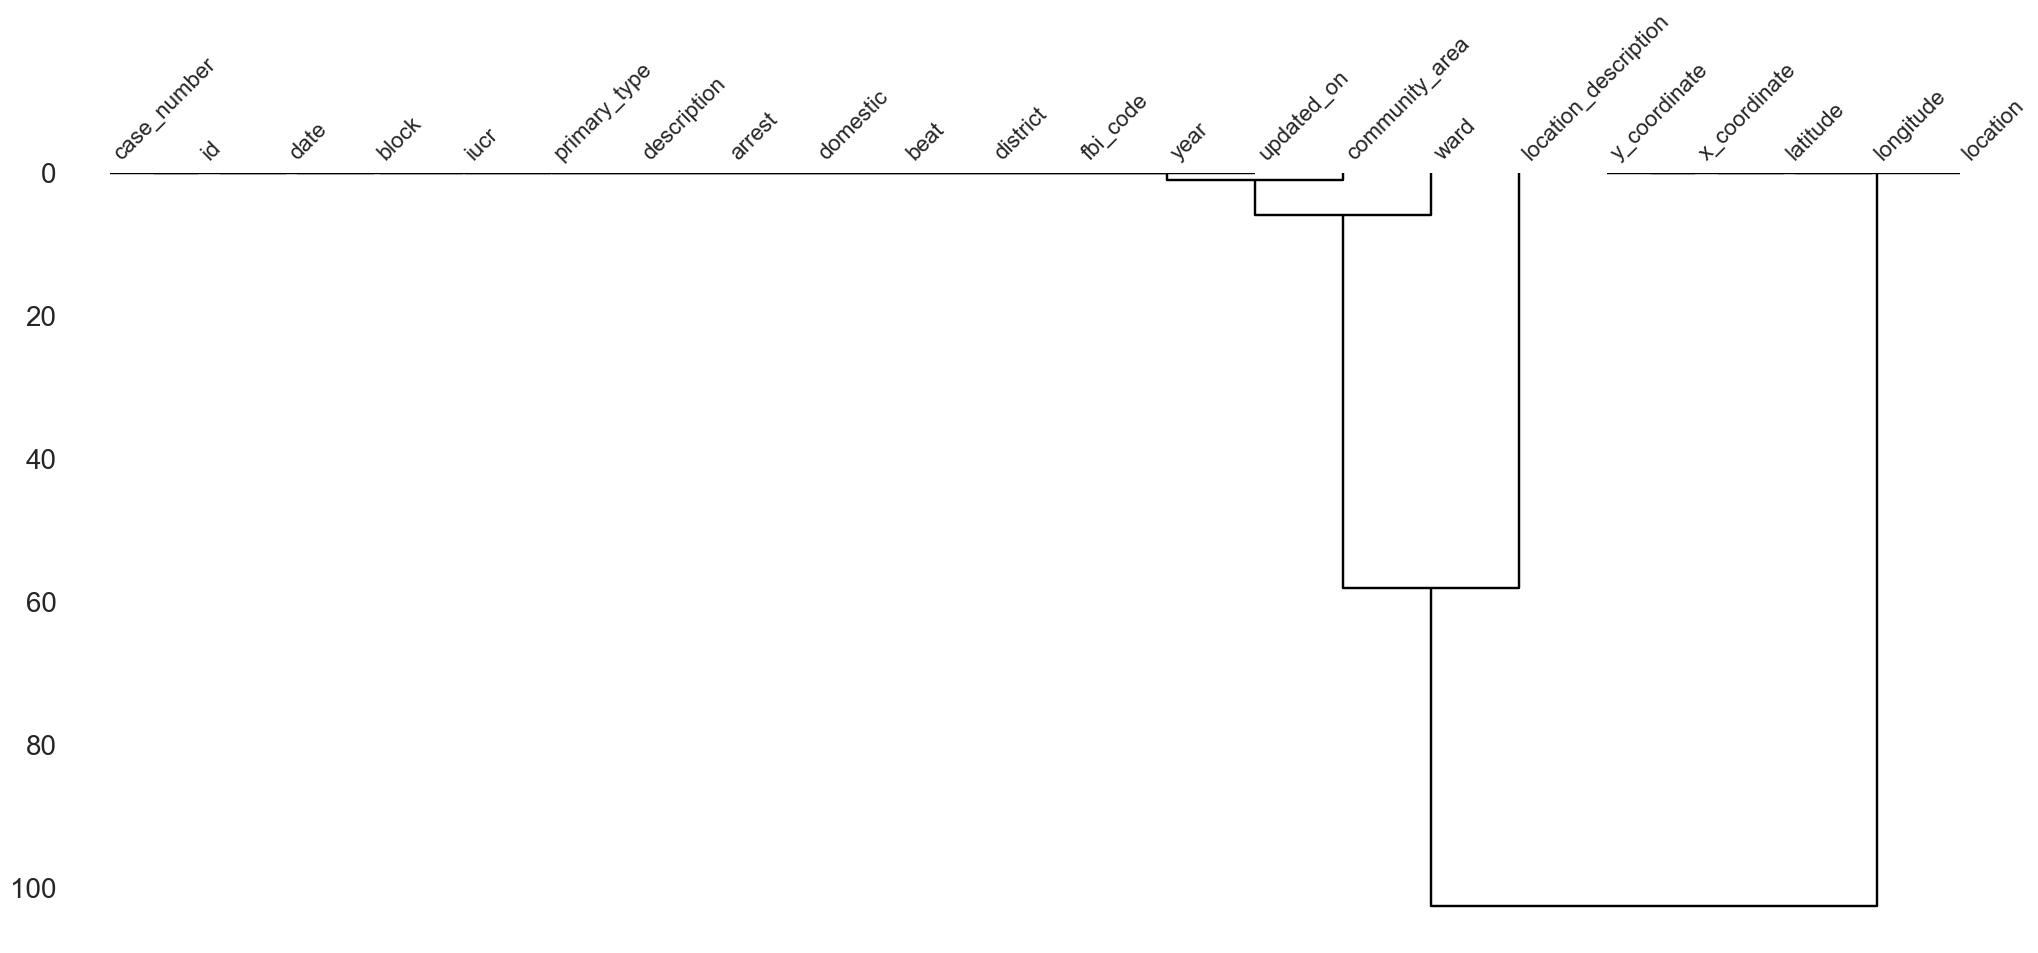

In [981]:
import missingno as msno 
msno.dendrogram(crimes_df)

In [982]:
crimes_df.dropna(subset = ['latitude','longitude','ward'], inplace = True)
crimes_df.reset_index(drop = True, inplace = True)
crimes_df['location_description'] = crimes_df['location_description'].fillna('Unavailable')

In [983]:
crimes_df.drop(['id','case_number','location'],axis=1,inplace=True)


In [984]:
crimes_df.shape


(669975, 19)

The x coordinate and y coordinate values are closely correlated with the null values of latitude and longitude, as can be seen from the dendogram above. If one of the values in this co-relation has a value of 1, it means that the other value likewise has a value of 1.

Therefore, it is safe to discard observations in which one of the values is zero. This shouldn't have an impact on our data and should also prevent the loss of significant observations.

In [985]:
crimes_df.isna().sum()

date                    0
block                   0
iucr                    0
primary_type            0
description             0
location_description    0
arrest                  0
domestic                0
beat                    0
district                0
ward                    0
community_area          0
fbi_code                0
x_coordinate            0
y_coordinate            0
year                    0
updated_on              0
latitude                0
longitude               0
dtype: int64

In [986]:
# size of data after cleaning
crimes_df.size

12729525

In [987]:
# Converting the numercial attributes to categorical attributes
crimes_df.year = pd.Categorical(crimes_df.year)
crimes_df.domestic = pd.Categorical(crimes_df.domestic)
crimes_df.arrest = pd.Categorical(crimes_df.arrest)
crimes_df.beat = pd.Categorical(crimes_df.beat)
crimes_df.district = pd.Categorical(crimes_df.district)
crimes_df.ward = pd.Categorical(crimes_df.ward)
crimes_df.community_area = pd.Categorical(crimes_df.community_area)

In [988]:
# Dropping the attributes date,block,iucr,primary_type,description,location_description,fbi_code,updated_on,x_coordinate,y_coordinate.
crimes_dff = crimes_df.drop(['date','block','iucr','primary_type','description','location_description','fbi_code','updated_on','x_coordinate','y_coordinate'],axis = 1)

In [989]:
crimes_dff = pd.get_dummies(crimes_dff,drop_first=True)

In [992]:
# Train test spliting the data with test size 30%
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(crimes_dff.drop(['arrest_True'],axis=1),crimes_dff['arrest_True'], test_size=0.3,random_state=0)

In [993]:
# Using Gaussain to predict if arrest happens or not
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)

In [994]:
# Displaying confusion matrix
from sklearn import metrics
from sklearn.metrics import classification_report
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
print(conf_matrix)

[[73695 92946]
 [ 9483 24869]]


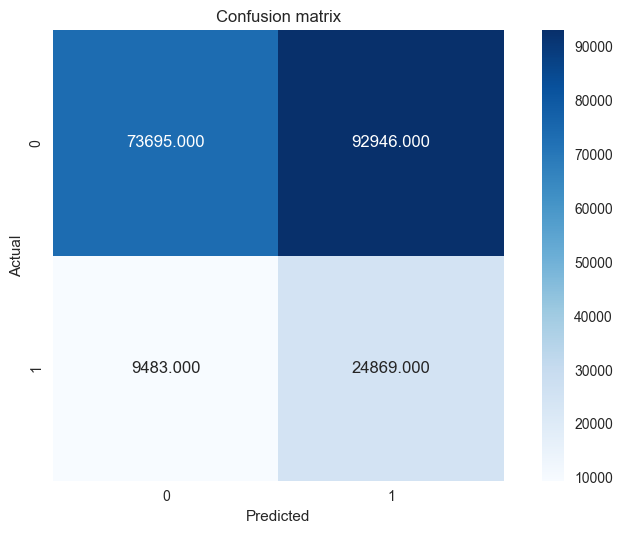

In [995]:
import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

Classification report and accuracy.

In [996]:
print('Accuracy = ',metrics.accuracy_score(y_test, y_pred))
print('Error = ',1 - metrics.accuracy_score(y_test, y_pred))
print('Precision = ',metrics.precision_score(y_test, y_pred,))
print('Recall = ',metrics.recall_score(y_test, y_pred))
print('F-1 Score = ',metrics.f1_score(y_test, y_pred))
print('Classification Report\n',metrics.classification_report(y_test, y_pred))

Accuracy =  0.49038523729682126
Error =  0.5096147627031787
Precision =  0.2110851759113865
Recall =  0.7239462040055892
F-1 Score =  0.3268645632758745
Classification Report
               precision    recall  f1-score   support

           0       0.89      0.44      0.59    166641
           1       0.21      0.72      0.33     34352

    accuracy                           0.49    200993
   macro avg       0.55      0.58      0.46    200993
weighted avg       0.77      0.49      0.55    200993



C:\Users\syarla3\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


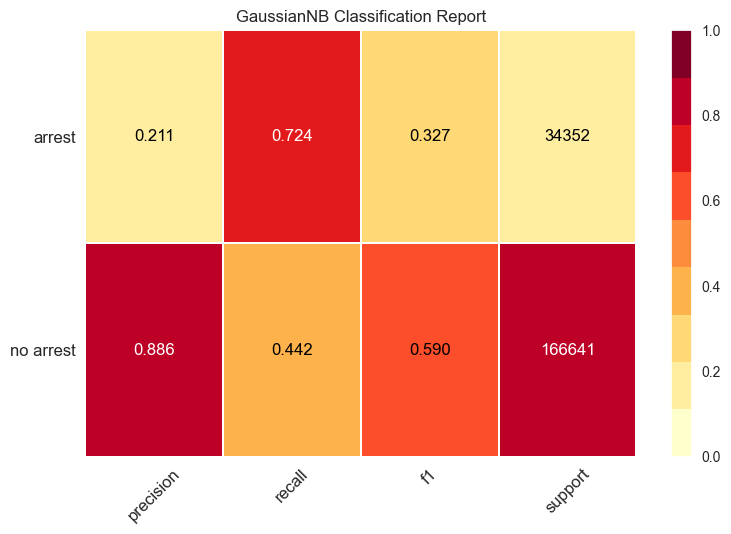

<AxesSubplot: title={'center': 'GaussianNB Classification Report'}>

In [997]:
from yellowbrick.classifier import ClassificationReport
classes=['no arrest','arrest']
visualizer = ClassificationReport(classifier, classes=classes, support=True)

visualizer.fit(x_train, y_train)        # Fit the visualizer and the model
visualizer.score(x_test, y_test)        # Evaluate the model on the test data
visualizer.show() 

##### Observation: By classification report,
- Precision: In the case where no arrest was predicted as positive 88% were correctly predicted. 
- Recall: In the case of an arrest 73% were classified correctly when an actual arrest happened.
- f1: The weighted harmonic mean of precision and recall is a good value if its closer to 1 but Gaussian classifier is low in term of f1 score which means we have to choose a better model.
- Support: This shows the number of actual occurences of the classes in teh dataset we see that we have 166684 instances of no arrest whereas only 34308 instances of arrest.This is the main reason we have high precission for no arrest whereas a low value for arrest.

Text(0, 0.5, 'True Positives:')

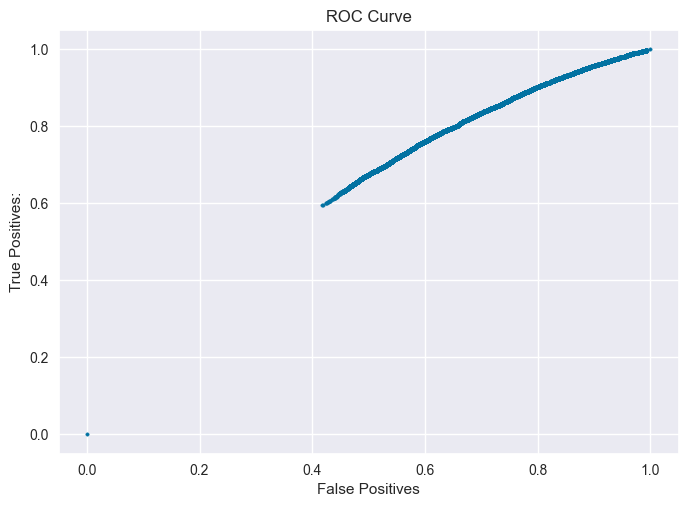

In [998]:
#Plotting the ROC Curve to analyse the model
from sklearn.metrics import roc_auc_score, roc_curve
false_positives,true_positives,thresholds = roc_curve(y_test,visualizer.predict_proba(x_test)[:,1])
plt.scatter(false_positives ,true_positives, s = 6)
plt.title('ROC Curve')
plt.xlabel('False Positives')
plt.ylabel('True Positives:')

#### Observation: The model have accuracy of 49% which means it can be further improved.The same can be seen even through ROC curve.The curve is not near to top left corver